# TripAdviser Restaurant Rating

<b>Business Goal:  </b> to predict the Tripadvisor Restaurant rating based on a historical dataset<br><br>

<b>General Comments:</b><br>
1) the initial train dataset showed MAE 0.1688<br>
2) an additional dataset (100k+ lines) has been used to improve the score  <br>
3) a few attempts to improve the score was applies but failed (see the relevant marks below) <br>
4) seems like the primitive text analysis ('Reviews' datafield), which was introduced in the <i>def features_proccessing()</i>  didn't work well. Plus a mistake in the code was found. 

<b>Further improvements:</b> 1) I would play with the "Reviews" datafield as it was shown dramatic improvement on the initial dataset (MAE = 0.12+) but the model was overfitted as the Kaggle set test showed<br>

If you have questions or comments be free to message me.

## libs & drivers import

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split  
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from IPython.display import Audio, display
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from datetime import datetime
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tripadvisor-competition-additional-dataset/positive_adj.txt
/kaggle/input/tripadvisor-competition-additional-dataset/negative_adj.txt
/kaggle/input/tripadvisor-competition-additional-dataset/population_and_tourists.txt
/kaggle/input/tripadvisor-competition-additional-dataset/additional_dataset.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [4]:
# notification - just to make the life easier and more relax
sound = 'https://freesound.org/data/previews/29/29589_215874-lq.mp3'

def allDone():
    display(Audio(url=sound, autoplay=True))

## Dataset Upload & Setup

In [5]:

file_path = '/kaggle/input/sf-dst-restaurant-rating/'

train_set = pd.read_csv(file_path + 'main_task.csv')

# add additional dataset & aling datafields with the initial one
additional_train_set = pd.read_csv('../input/tripadvisor-competition-additional-dataset/additional_dataset.csv')
additional_train_set['Restaurant_id'] = additional_train_set['Unnamed: 0']
additional_train_set.drop(['Unnamed: 0', 'Name'], axis=1, inplace=True)

train_set = pd.concat([train_set, additional_train_set])

test_set = pd.read_csv(file_path + 'kaggle_task.csv')

train_set['sample'] = 1  # mark the train set
test_set['sample'] = 0  # mark the test set
test_set['Rating'] = 0  # define the absent field for the test set as well

df = train_set.append(test_set, sort=False).reset_index(drop=True)
df.dropna(subset=['Rating', 'Reviews', 'Ranking'], axis=0, inplace=True)

Solution = pd.DataFrame()  #DataFrame for the Kaggle Data Collection
Solution['Restaurant_id'] = df.query('sample == 0')[
    'Restaurant_id']  # keep IDs as the Kaggle dataset solution requirements

all features processing was packed into a function to ease the further experiments with the datasets



In [6]:

def features_proccessing(df):

    df = df.rename(
        columns={
            'Number of Reviews': 'Number_of_Reviews',
            'Price Range': 'Price_Range',
            'Cuisine Style': 'Cuisine_Style'
        })
    # add "some IDs"
    df['some ID'] = df['ID_TA'].apply(lambda x: float(x[1:]))
    df['some ID 2'] = df['URL_TA'].apply(lambda x: float(x[20:26]))
    df.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)

    # Restaturantу Chain Network
    restaurant_chain = set()
    for chain in df['Restaurant_id']:
        #print(chain)
        restaurant_chain.update(str(chain))

    def find_item(cell):
        #print(cell)
        if item in str(cell):
            return 1
        return 0

    for item in restaurant_chain:
        df['Network'] = df['Restaurant_id'].apply(find_item)


# a new feature "Country Code"
    city_country = {
        'London': 'UK',
        'Paris': 'France',
        'Madrid': 'Spain',
        'Barcelona': 'Spain',
        'Berlin': 'Germany',
        'Milan': 'Italy',
        'Rome': 'Italy',
        'Prague': 'Czech',
        'Lisbon': 'Portugalia',
        'Vienna': 'Austria',
        'Amsterdam': 'Nederlands',
        'Brussels': '144784 ',
        'Hamburg': 'Germany',
        'Munich': 'Germany',
        'Lyon': 'France',
        'Stockholm': 'Sweden',
        'Budapest': 'Hungary',
        'Warsaw': 'Poland',
        'Dublin': 'Ireland',
        'Copenhagen': 'Denmark',
        'Athens': 'Greece',
        'Edinburgh': 'Schotland',
        'Zurich': 'Switzerland',
        'Oporto': 'Portugalia',
        'Geneva': 'Switzerland',
        'Krakow': 'Poland',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Bratislava': 'Slovakia',
        'Luxembourg': 'Luxembourg',
        'Ljubljana': 'Slovenija'
    }

    df['County Code'] = df['City'].map(city_country)

    le = LabelEncoder()

    le = LabelEncoder()
    le.fit(df['County Code'])
    df['County Code'] = le.transform(df['County Code'])

    # feature 'City' as a numerical feature
    le.fit(df['City'])
    df['City Code'] = le.transform(df['City'])

    # a dummy variable "Capital"
    capitals = [
        'London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon',
        'Vienna', 'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw',
        'Dublin', 'Copenhagen', 'Athens', 'Oslo', 'Helsinki', 'Bratislava',
        'Luxembourg', 'Ljubljana', 'Edinburgh'
    ]
    df['Capital'] = df['City'].apply(lambda x: 1 if x in capitals else 0)

    # new feature "quantity of restaurants per City"
    df['Rests per City'] = df['City'].map(
        df.groupby(['City'])['Restaurant_id'].count().to_dict())
    df.drop(['Restaurant_id'], axis=1, inplace=True)

    #new feature "Rests per capita", "Population"
    population = {
        'Paris': 2190327,
        'Stockholm': 961609,
        'London': 8908081,
        'Berlin': 3644826,
        'Munich': 1456039,
        'Oporto': 237591,
        'Milan': 1378689,
        'Bratislava': 432864,
        'Vienna': 1821582,
        'Rome': 4355725,
        'Barcelona': 1620343,
        'Madrid': 3223334,
        'Dublin': 1173179,
        'Brussels': 179277,
        'Zurich': 428737,
        'Warsaw': 1758143,
        'Budapest': 1752286,
        'Copenhagen': 615993,
        'Amsterdam': 857713,
        'Lyon': 506615,
        'Hamburg': 1841179,
        'Lisbon': 505526,
        'Prague': 1301132,
        'Oslo': 673469,
        'Helsinki': 643272,
        'Edinburgh': 488100,
        'Geneva': 200548,
        'Ljubljana': 284355,
        'Athens': 664046,
        'Luxembourg': 115227,
        'Krakow': 769498
    }

    df['Population'] = df['City'].map(population)
    df['Rests per Capita'] = df['Rests per City'] / df['Population']

    #a new feature 'relative ranking'
    df['Relative Ranking'] = df['Ranking'] / df['Rests per City']

    # a dummy variable "Pricing" based on price range "$", "$$ - $$$", "$$$"
    price_range = {'$': 0, '$$ - $$$': 1, '$$$$': 2}

    df['Pricing'] = df['Price_Range'].map(price_range)
    df['Pricing'].fillna(df['Pricing'].mean(), inplace=True)

    df['Price_Unknown'] = df['Price_Range'].isna().astype('int32')

    del df['Price_Range']

    # a new feature "quantity of reviews per a City"
    df['Number_of_Reviews'].fillna(df['Number_of_Reviews'].mean(), inplace=True)
    df['fb per City'] = df['Number_of_Reviews'].map(
        df.groupby(['Number_of_Reviews'
                    ])['Number_of_Reviews'].count().to_dict())

    #df['fb / Rest / Person'] = df['Number_of_Reviews'] / df['Rests per Capita'] - excluded as MAE is better without this feature

    # a dummy variable "Population and Tourists flow"
    population_tourists = list(
        open('../input/tripadvisor-competition-additional-dataset/population_and_tourists.txt', 'r'))

    population_dict = {}
    tourists_dict = {}

    for city in population_tourists:
        data = city.rstrip().split(' ')
        population_dict.update({data[0]: data[1]})
        tourists_dict.update({data[0]: data[2]})

    def data_update_population(city):
        try:
            city = str(city)
            return float(population_dict.get(city))
        except:
            pass

    def data_update_tourists(city):
        try:
            city = str(city)
            return float(tourists_dict.get(city))
        except:
            pass

    df['population'] = df['City'].apply(data_update_population)
    df['tourists'] = df['City'].apply(data_update_tourists)

    df[['tourists', 'population']] = df[['tourists', 'population']].fillna(0)
    df[['tourists', 'population']] = df[['tourists',
                                         'population']].astype('int64')

    del df['City']

    # a dummy variables "cuisines"
    df['Cuisine Qntty'] = df['Cuisine_Style'].str[2:-2].str.split(
        "', '").str.len().fillna(1)

    del df['Cuisine_Style']

    #split reviews (feedback (fb)) by review_content and by date of review
    reviews = df['Reviews'].str[3:-3].str.split(', ').dropna(0)

    def fill_up_new_column(serie, column):
        serie = serie[3:-3].split(', ')
        try:
            if len(serie) == 4:
                return serie[column]
            elif len(serie) == 2:
                if column == 1 and column == 2:
                    return serie[column]
                elif column == 3 and column == 4:
                    return ''
            else:
                return ''
        except:
            return ''

    df['fb1_content'] = df['Reviews'].apply(fill_up_new_column, column=0)
    df['fb1_date'] = df['Reviews'].apply(
        fill_up_new_column,
        column=2)  #data contains more than 2 feedbacks at some point
    df['fb2_content'] = df['Reviews'].apply(fill_up_new_column, column=1)
    df['fb2_date'] = df['Reviews'].apply(fill_up_new_column, column=3)

    #cleanup the date info
    df['fb1_date'] = df['fb1_date'].apply(
        lambda x: re.findall(r'\d\d/\d\d/\d{4}', str(x)))
    df['fb2_date'] = df['fb2_date'].apply(
        lambda x: re.findall(r'\d\d/\d\d/\d{4}', str(x)))

    # a new dummy 'no feedback'
    df['fb_none'] = df['Reviews'].apply(
        lambda x: 0 if bool(re.search('\w+', x)) == True else 1)

    df.drop(['Reviews'], axis=1, inplace=True)

    # a dummy "days since the last review"
    df[['fb1_date', 'fb2_date']] = df[['fb1_date',
                                       'fb2_date']].fillna('01/01/2000')
    today = '03/04/2020'
    today = datetime.strptime(today, '%m/%d/%Y')

    def days_count(date):
        try:
            date = str(date)[2:-2]
            date = datetime.strptime(date, '%m/%d/%Y')
            time_delta = (today - date).days
        except:
            return 7368  # count empty datacells as 7368 days (since 01/01/2000) ... kind of 'a long period'
        return time_delta

    df['days fb1'] = df['fb1_date'].apply(days_count)
    df['days fb2'] = df['fb2_date'].apply(days_count)
    df.drop(['fb1_date', 'fb2_date'], axis=1, inplace=True)

    # add dummy "days between reviews"
    df['review_gap'] = df['days fb1'] - df['days fb2']

    # add dummy variables "feedback tonality"
    # (!)attention(!) there is a mistake in the code as a few tests showed
    # didn't clean up the code intentionally

    #negative_adj.txt & negative_adj.txt contain a list of positive/negative words 
    
    f = open('../input/tripadvisor-competition-additional-dataset/negative_adj.txt', 'r')
    negative_adj = []
    for line in f:
        negative_adj.append(line[:-1].lower())

    f = open('../input/tripadvisor-competition-additional-dataset/negative_adj.txt', 'r')
    positive_adj = []
    for line in f:
        positive_adj.append(line[:-1].lower())

    df['fb1_content'] = df['fb1_content'].fillna('no data')
    df['fb2_content'] = df['fb2_content'].fillna('no data')

    def find_item(feedback, word):
        if feedback.find(word) > 0:
            return 1
        else:
            return 0

    for word in positive_adj:
        df['fb1_positive'] = df['fb1_content'].apply(find_item, word=word)

    for word in negative_adj:
        df['fb1_negative'] = df['fb1_content'].apply(find_item, word=word)

    for word in positive_adj:
        df['fb2_positive'] = df['fb2_content'].apply(find_item, word=word)

    for word in negative_adj:
        df['fb2_negative'] = df['fb2_content'].apply(find_item, word=word)

    df.drop(['fb1_content', 'fb2_content'], axis=1, inplace=True)

    df = df.drop(
        ['Network', 'Capital'], axis=1
    )  #features were droped as a few experiments showed that MAE was better without them

    return df

## Baseline Model

this section introduces the baseline modeling

In [7]:
# rating - the fuction aligns the final model resul to the Trip Advisor scale, which is multiple to 0.25 
def rating(prediction):
        if prediction < 0.25:
            return 0
        elif 0.25 < prediction <= 0.75:
            return 0.5
        elif 0.75 < prediction <= 1.25:
            return 1
        elif 1.25 <prediction <= 1.75:
            return 1.5
        elif 1.75 < prediction <= 2.25:
            return 2
        elif 2.25 < prediction <= 2.75:
            return 2.5
        elif 2.75 < prediction <= 3.25:
            return 3
        elif 3.25 < prediction <= 3.75:
            return 3.5
        elif 3.75 < prediction <= 4.25:
            return 4
        elif 4.25 < prediction <= 4.75:
            return 4.5
        else:
            return 5

In [8]:
def baseline_model(df_model):
    X = df_model.query('sample == 1').drop(['sample','Rating'], axis=1)
    y = df_model.query('sample == 1')['Rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])

    mae = round(metrics.mean_absolute_error(y_test, y_pred),4)
    print('MAE:', mae)

    #plot the most valuable features
    plt.rcParams['figure.figsize'] = (5,5)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(25).plot(kind='barh')
    
    return

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE: 0.1047


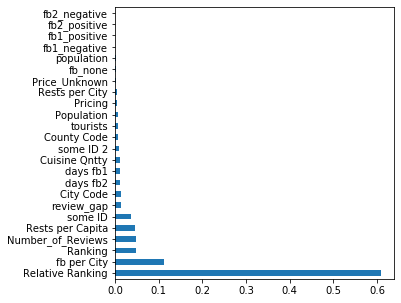

In [9]:
df_model = features_proccessing(df)
baseline_model(df_model)
allDone()

### ( FAIL ) attemp to drop some features , which showed mutual correlation

#### the features correlation matrix

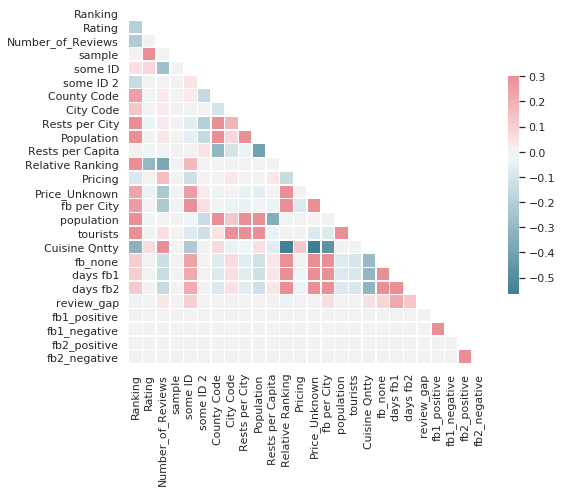

In [10]:
import seaborn as sns
import numpy as np

sns.set(style="white")
corr = df_model.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### ( FAIL ) as 'Cuisine Qntty' has a corr with 'Relative Ranking' & 'Price_Unknown', let's drop 'Cuisine Quantity' to check the accuracy

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE: 0.1049


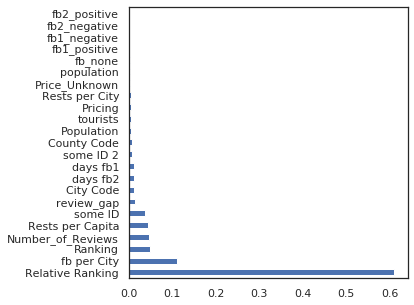

In [11]:
df_temp = df_model.drop('Cuisine Qntty', axis = 1)
baseline_model(df_temp)

### ( FAIL ) Polynom features

there was as improvement on the tests dataset but the Kaggle dataset showed a worse result

In [12]:
columns = list(df_model.columns)
columns.remove('Rating')

In [13]:
# add poly features
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(df_model[columns])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


MAE: 0.1579


CPU times: user 53min 39s, sys: 2.59 s, total: 53min 42s
Wall time: 13min 49s


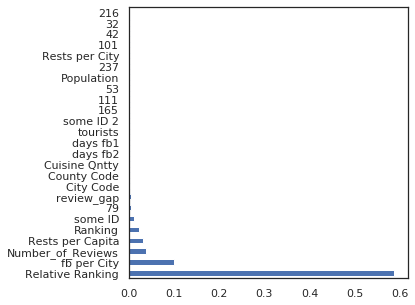

In [14]:
%%time
df1 = pd.concat([pd.DataFrame(poly_features), df_model], axis =1)
baseline_model(df1)
allDone()

Kaggle result is 0.20025

### ( FAIL ) Text Feedback Features


An attempt to convert the text feedback into a feature. The most promising action but the current version failed due to the overfitting.

### Feedback text analysis

In [15]:
df['all_reviews'] = df['Reviews']
df['all_reviews'].replace('[[], []]', 'empty', inplace=True)

def clean_feedback(content):
    pattern = r'[^a-zA-Z ]'
    content = re.sub(pattern,'',(str(content).lower()))
    return content

df['all_reviews'] = df['all_reviews'].apply(clean_feedback)

In [16]:
# assumption: all comments with rating < negative_cutoff are negative (label = 0)
# all comments with rating >= positive_cutoff are positive (label = 1)

negative_cutoff = 3.0
positive_cutoff = 4.0

df_content = pd.DataFrame()
df_content = df.query('sample == 1')[['Rating','all_reviews']]
df_content['feedback'] = None
df_content.reset_index(inplace = True)

In [17]:
for i in range (len(df_content)):
    if df_content.all_reviews.loc[i] != 'empty':
        if df_content.Rating.loc[i] >= positive_cutoff:
            df_content.feedback.loc[i] = 1
        elif df_content.Rating.loc[i] < negative_cutoff:
            df_content.feedback.loc[i] = 0
        else:
            df_content.feedback.loc[i] = None
    else:
        df_content.feedback.loc[i] = None

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


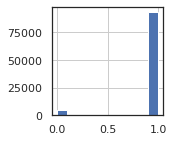

In [18]:
df_content.feedback.hist(figsize = (2,2))

as there is a huge disbalance, we consider only 'positive' as a feature as a start

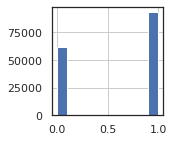

In [19]:
df_content.feedback = df_content.feedback.apply(lambda x: 0 if x == None else x)
df_content.feedback.hist(figsize = (2,2))
df_content = df_content.query('all_reviews != "empty"')
df_content.drop(['Rating'], axis = 1, inplace = True)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#stop_words = list(ENGLISH_STOP_WORDS) 
#vect.vocabulary_

### "positive" feature optimization based on the threshhold 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer

X = df_content.all_reviews
y = df_content.feedback

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cfm = confusion_matrix

text_clf = Pipeline([
                     ('CV', CountVectorizer(min_df=2)),
                     ('rf', RandomForestRegressor(n_jobs = -1, n_estimators=70))
                     ])
 
text_clf.fit(list(X_train), y_train.array)

Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decr

In [22]:
y_pred = []
for x in X_test:
    y_pred.append(text_clf.predict([x])[0])
    
y_pred = pd.Series(y_pred)
allDone()

In [23]:
y_pred_adj = []
treshhold = 0.54122

for y in y_pred:
    y_pred_adj.append(1 if y > treshhold else 0)

0.7823866955257732


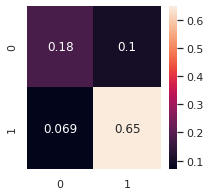

In [24]:
from sklearn.metrics import f1_score

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_adj, normalize='all')
print(f1_score (y_test, y_pred_adj, average='macro'))

fig, ax = plt.subplots(figsize=(3,3)) 
sns.heatmap(cnf_matrix, annot=True)

In [25]:
# optimize f1_score based on treshhold:

f1_thresh = {}

for threshhold in range (100, 900, 5):
    y_pred_adj = []
    
    for y in y_pred:
        y_pred_adj.append(1 if y > threshhold/1000 else 0)
        
    #cnf_matrix = metrics.confusion_matrix(y_test, y_pred_adj, normalize='all')
    f1 = f1_score (y_test, y_pred_adj, average='macro')
    f1_thresh[threshhold/1000] = f1

print(f'threshhold / f1:  {max(f1_thresh, key=f1_thresh.get)} / {max(f1_thresh.values())}')

threshhold / f1:  0.5 / 0.7833905894027058


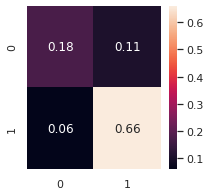

In [26]:
# find optimized confusion_matrix

y_pred_adj = []
for y in y_pred:
    y_pred_adj.append(1 if y > max(f1_thresh, key=f1_thresh.get) else 0)

fig, ax = plt.subplots(figsize=(3,3)) 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_adj, normalize='all')
sns.heatmap(cnf_matrix, annot=True)

threshhold / f1:  0.001 / 0.7166891808915633


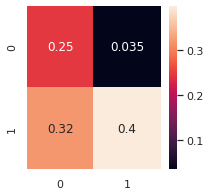

In [27]:
# find with TRUE POSITIVE focus 

f1_thresh = {}

for threshhold in range (1, 900, 5):
    y_pred_adj = []
    
    for y in y_pred:
        y_pred_adj.append(1 if y > threshhold/1000 else 0)
        
    #cnf_matrix = metrics.confusion_matrix(y_test, y_pred_adj, normalize='all')
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred_adj, normalize='all')
    f1_thresh[threshhold/1000] = cnf_matrix[1,1]

print(f'threshhold / f1:  {max(f1_thresh, key=f1_thresh.get)} / {max(f1_thresh.values())}')
fig, ax = plt.subplots(figsize=(3,3)) 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_adj, normalize='all')
sns.heatmap(cnf_matrix, annot=True)

- as the result, based on f1_score, the threshhold shall be 0.605<br>
- next time GridSearchCV should be applied

## Kaggle data file

In [ ]:
# train model on all dataset without "train", "test" subsets 

# df_model = features_proccessing(df)


X = df_model.query('sample == 1').drop(['sample','Rating'], axis=1)
y = df_model.query('sample == 1')['Rating']

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
model.fit(X, y)

X_kaggle = df_model.query('sample == 0').drop(['sample','Rating'], axis=1)
y_kaggle = model.predict(X_kaggle)

for i in range(y_kaggle.size):
    y_kaggle[i]=rating(y_kaggle[i])

Solution['Rating'] = y_kaggle

Solution.to_csv('solution14-27-04-20.csv', index = False)
allDone()